# Introduction To Numerical Probability Tests

In this notebook, we verify various functions used to numerically obtain probability distributions from a system of ODEs. This notebook contains:

- Steady State Distribution
- Joint Distribution Between Survival Times and System State
- Normalized Joint Distribution
- Detection Event Times & State Probabilities After A Detection Event
- Code for All Distribution Generation Functions
- Comparison with Analytical Results

This notebook is motivated by the fact that most systems do not admit closed-form analytic solutions for their probabilitiy distributions and thus mutual information. Here, we show that it is possible to derive mutual information results with only numerical solutions, and that such results agree with our earlier analytical results.

# Steady State Distribution

Code for numerically simulating the ODE system and its resulting steady state distribution.

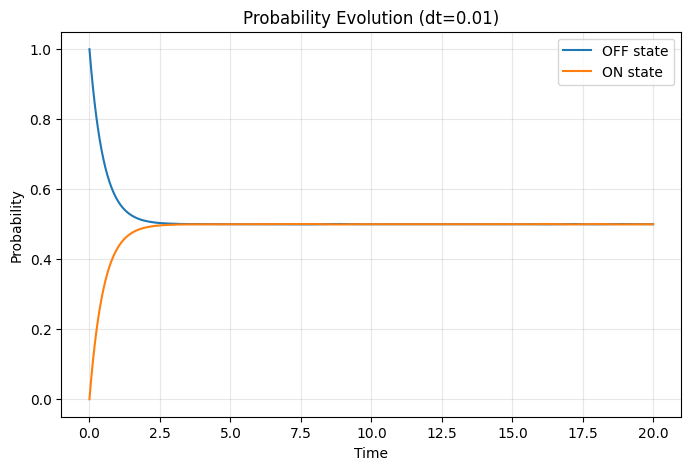

Steady state probabilities:
OFF: 0.5000971522336403
ON: 0.49990284776635974


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from binary_markov_funcs import two_state_system_dt, two_state_system_detection_dt

# 2. Simulation parameters (user can change these)
initial_p = np.array([1.0, 0.0])  # Start in OFF state
t_max = 20.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

k_on = 1.0
k_off = 1.0

# 3. Run simulation
solution = solve_ivp(two_state_system_dt, [0, t_max], initial_p, 
                    t_eval=t_eval, method='RK45', args=(k_off, k_on))
steady_state = solution.y[:, -1]  # Final probabilities

# 4. Plot the time evolution
plt.figure(figsize=(8, 5))
plt.plot(solution.t, solution.y[0], label='OFF state')
plt.plot(solution.t, solution.y[1], label='ON state')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Probability Evolution (dt={})'.format(dt))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Steady state probabilities:")
print("OFF:", steady_state[0])
print("ON:", steady_state[1])

# Joint Distribution Between Survival Times and System State

Code for numerically simulating the ODE system with detection events, describing how the probability that a detection event has not occured continually decreases. Note that we simulate for each possible initial condition, but in practice it's impossible for $x = 0$ to produce a detection event.

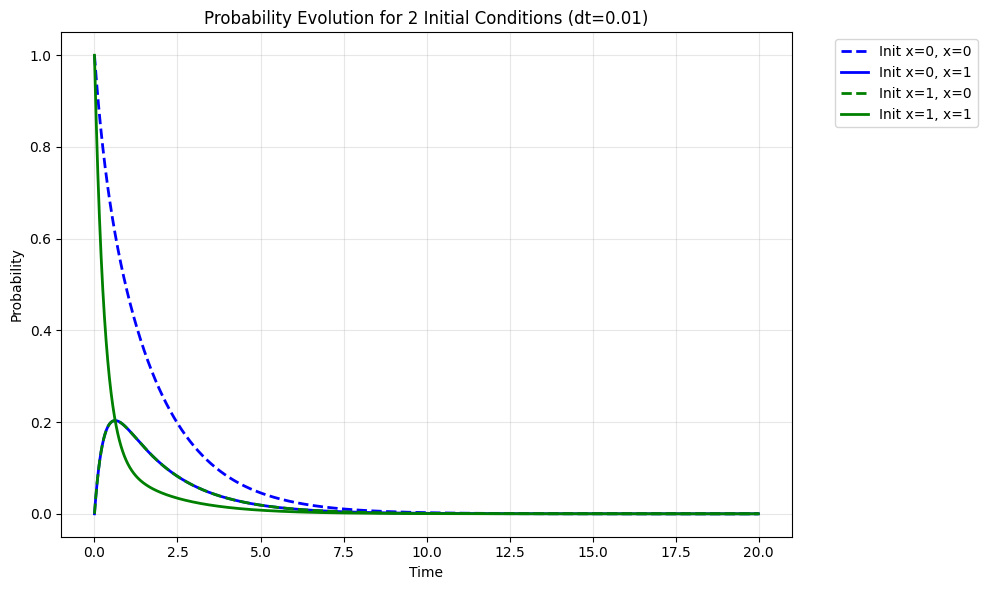

In [2]:
# Simulation parameters (user can change these)
num_states = 2  # Number of states in the system (user specifies this)
t_max = 20.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)
num_time_points = len(t_eval)

solution = np.zeros((num_states, num_time_points, num_states))
alpha = 2.0
# Run simulation for each initial condition
for initial_state in range(num_states):
    # Create initial condition (100% in current state)
    initial_p = np.zeros(num_states)
    initial_p[initial_state] = 1.0
    
    # Solve ODE system
    sol = solve_ivp(two_state_system_detection_dt, [0, t_max], initial_p, 
                   t_eval=t_eval, method='RK45', args=(k_off, k_on, alpha))
    
    # Store solution in array (solution[initial_state, time_index, state_value])
    solution[initial_state, :, :] = sol.y.T

# 5. Save the full solution array
np.save('ode_solutions.npy', solution)

# 6. Plot the time evolution for each initial condition
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for different initial conditions
line_styles = ['--', '-', ':', '-.']      # Line styles for different states

for initial_state in range(num_states):
    for state_value in range(num_states):
        plt.plot(t_eval, solution[initial_state, :, state_value],
                color=colors[initial_state % len(colors)],
                linestyle=line_styles[state_value % len(line_styles)],
                linewidth=2,
                label=f'Init x={initial_state}, x={state_value}')

plt.xlabel('Time')
plt.ylabel('Probability')
plt.title(f'Probability Evolution for {num_states} Initial Conditions (dt={dt})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8. Example of loading later:
# loaded_solutions = np.load('ode_solutions.npy')
# print("Solution for initial x=0 at last time point:", loaded_solutions[0, -1, :])

# Time Since Last Detection Event (Normalized Joint Distribution)

Earlier, we computed the probability that given a particular initial state and a detection event, the system has yet to produce another detection event by time $t$. This is closely related to the probability that randomly observing our system yields a time t since the last detection event, but the former needs to be normalized first.

Initial condition 0 - total prob: 100.00
Initial condition 1 - total prob: 100.00


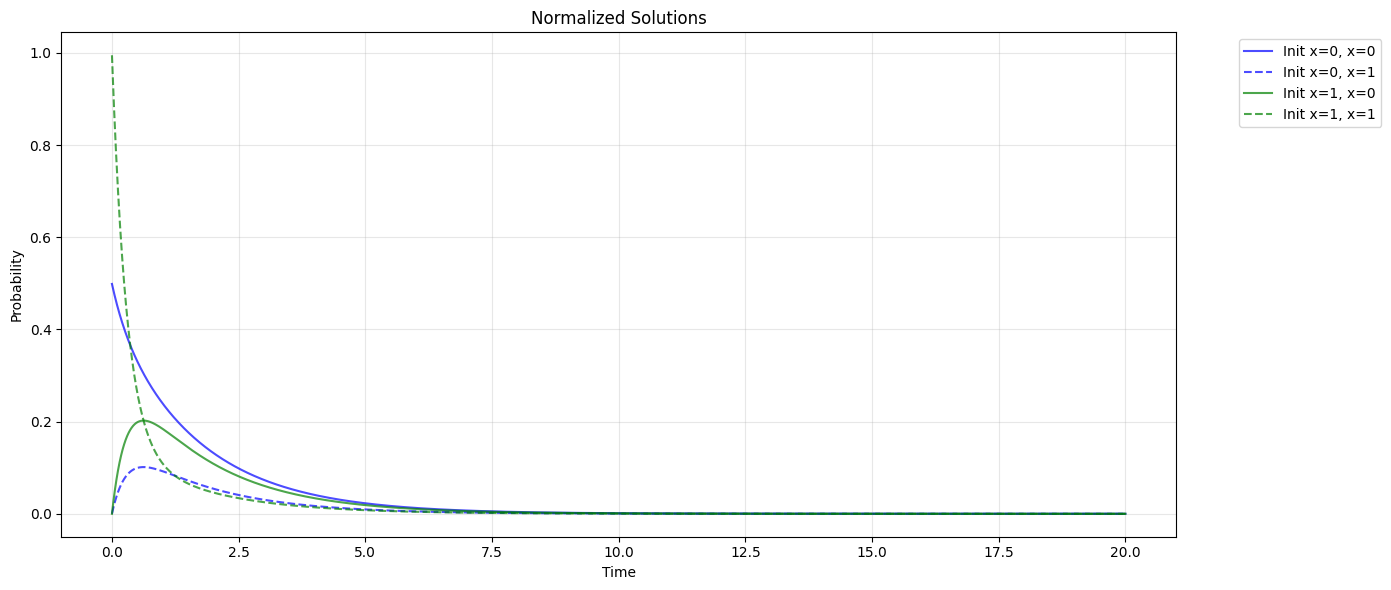

In [3]:
import numpy as np
import matplotlib.pyplot as plt
t_max = 20.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Load the original solution array
solution = np.load('ode_solutions.npy')  # Shape: [initial_conditions, time_points, states]

# Normalize each initial condition's solution
normalized_solution = np.zeros_like(solution)
for initial_state in range(solution.shape[0]):
    # Sum over states for each time point (keep dimensions for broadcasting)
    norm_factors = np.sum(solution[initial_state]*dt)
    normalized_solution[initial_state] = solution[initial_state] / norm_factors

# Verify normalization
for initial_state in range(normalized_solution.shape[0]):
    sums = np.sum(normalized_solution[initial_state])
    print(f"Initial condition {initial_state} - total prob: {(sums):.2f}")

# Plot settings
plt.figure(figsize=(14, 6))
t_eval = np.linspace(0, solution.shape[1]*dt, solution.shape[1])  # Time points
colors = ['b', 'g', 'r', 'c', 'm', 'y']
line_styles = ['-', '--', ':', '-.']

# Plot normalized solutions
for initial_state in range(normalized_solution.shape[0]):
    for state_value in range(normalized_solution.shape[2]):
        plt.plot(t_eval, normalized_solution[initial_state, :, state_value],
                color=colors[initial_state % len(colors)],
                linestyle=line_styles[state_value % len(line_styles)],
                alpha=0.7,
                label=f'Init x={initial_state}, x={state_value}')
plt.title('Normalized Solutions')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Detection Event Times & State Probabilities After A Detection Event

From the original ODE solution for the joint probabilities, we marginalize to obtain the distribution of survival times, and take the derivative to obtain the probability a detection event occurs at time $t$ after an initial detection event and initial condition.

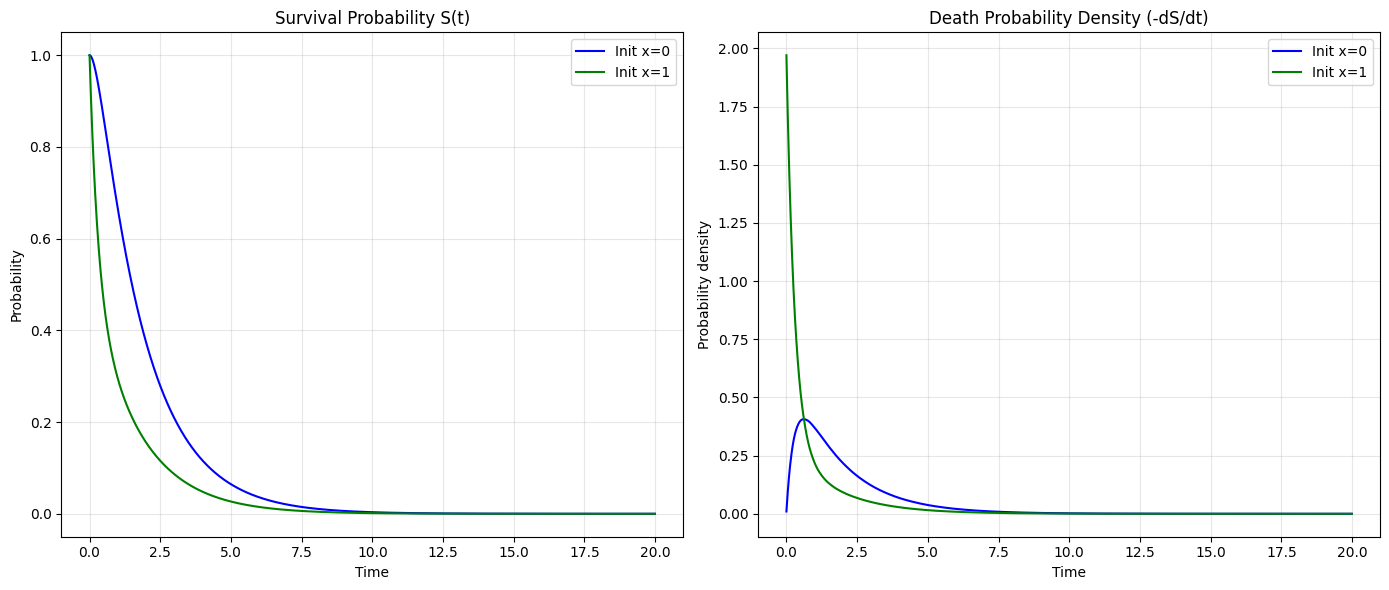

Integral of death probability (should be 1 - S_final):
Initial x=0: 0.9999 (S_final = 0.0000)
Initial x=1: 0.9901 (S_final = 0.0000)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
t_max = 20.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)

# Load the original solution array
solution = np.load('ode_solutions.npy')  # Shape: [initial_conditions, time_points, states]

# Create marginalized array by summing over x values (axis=2)
marginalized = np.sum(solution, axis=2)  # Shape: [initial_conditions, time_points]
# Compute death probability density (negative time derivative of S)
death_prob = -np.diff(marginalized, axis=1) / dt  # Finite difference derivative
# Pad with zero to match original array size
death_prob = np.pad(death_prob, ((0,0),(0,1)), mode='constant') #Shape: [initial_conditions, time_points]

# Plot settings
plt.figure(figsize=(14, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
line_styles = ['-', '--']

# Plot 1: Survival probability
plt.subplot(1, 2, 1)
for initial_state in range(marginalized.shape[0]):
    plt.plot(t_eval, marginalized[initial_state, :],
            color=colors[initial_state % len(colors)],
            label=f'Init x={initial_state}')
plt.title('Survival Probability S(t)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Death probability density
plt.subplot(1, 2, 2)
for initial_state in range(death_prob.shape[0]):
    plt.plot(t_eval, death_prob[initial_state, :],
            color=colors[initial_state % len(colors)],
            label=f'Init x={initial_state}')
plt.title('Death Probability Density (-dS/dt)')
plt.xlabel('Time')
plt.ylabel('Probability density')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Verification: The integral should be 1 - S(∞)
print("Integral of death probability (should be 1 - S_final):")
for initial_state in range(death_prob.shape[0]):
    integral = np.trapezoid(death_prob[initial_state], t_eval)
    print(f"Initial x={initial_state}: {integral:.4f} (S_final = {marginalized[initial_state,-1]:.4f})")

Given a detection event occurs at time $t$ after an initial detection event, we can calculate the probabilities of $x$ right before the detection event, and then conditioned on the detection event occuring (which increases the probability of states that have higher chances of detection events). For the binary markov system, this is trivial since only one state can generate detection events.

Verification - min/max of sums: 0.9999999999999998 1.0000000000000002


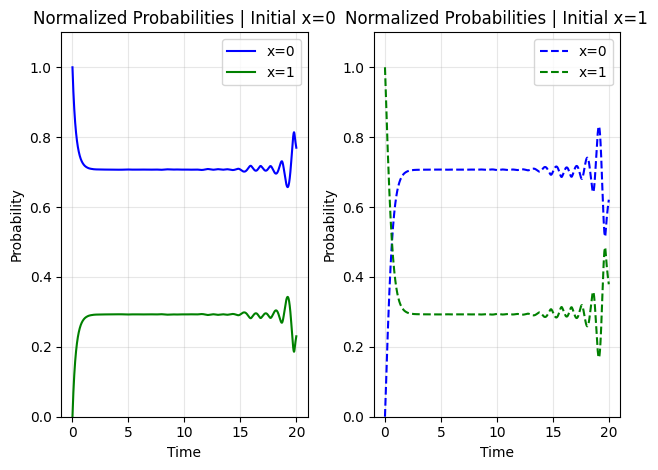

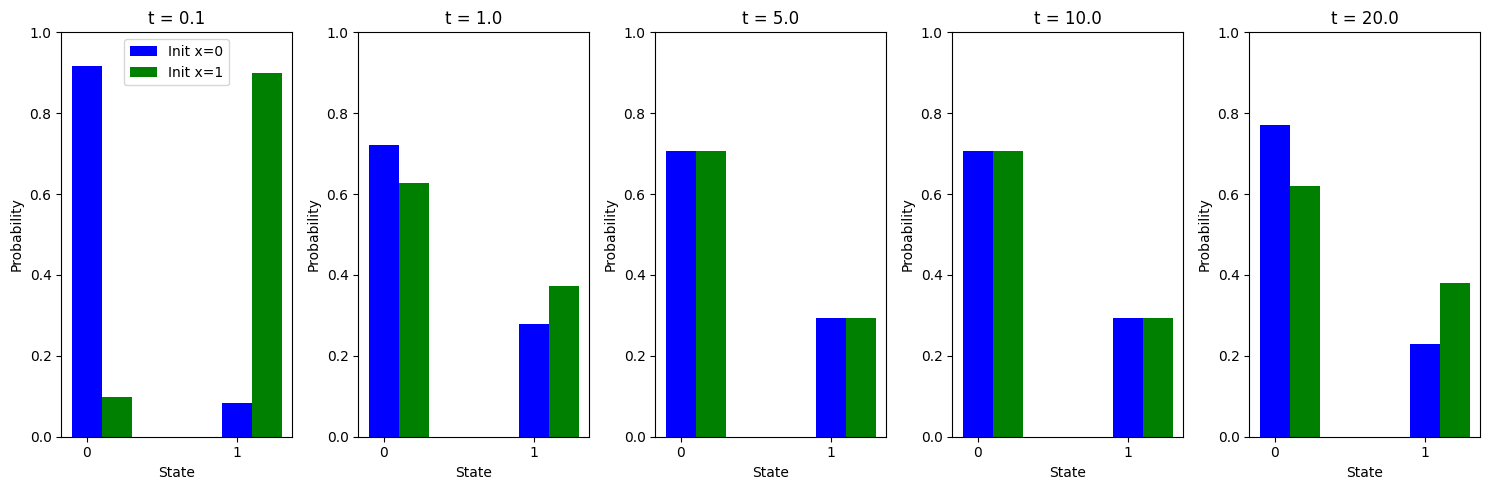

In [5]:
# Load the original solution array
solution = np.load('ode_solutions.npy')  # Shape: [initial_conditions, time_points, states]

# 1. Compute normalization factors (sum over states for each [initial, time])
norm_factors = np.sum(solution, axis=2, keepdims=True)  # Keep dimensions for broadcasting

# 2. Normalize the array (avoid division by zero)
normalized_solution = solution / norm_factors

# 3. Verification (should be 1 or 0 where norm_factor was 0)
check_sums = np.sum(normalized_solution, axis=2)
print("Verification - min/max of sums:", np.min(check_sums), np.max(check_sums))

# Plot for each initial condition
for initial_state in range(solution.shape[0]):
    plt.subplot(1, solution.shape[0], initial_state+1)
    
    for state in range(solution.shape[2]):
        plt.plot(t_eval, normalized_solution[initial_state, :, state],
                color=colors[state],
                linestyle=line_styles[initial_state % len(line_styles)],
                label=f'x={state}')
    
    plt.title(f'Normalized Probabilities | Initial x={initial_state}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional plot: State probabilities at specific times
selected_times = [0.1, 1.0, 5.0, 10.0, 20.0]
time_indices = [np.argmin(np.abs(t_eval - t)) for t in selected_times]

plt.figure(figsize=(15, 5))
for i, t_idx in enumerate(time_indices):
    plt.subplot(1, len(time_indices), i+1)
    
    for initial_state in range(solution.shape[0]):
        plt.bar(np.arange(solution.shape[2]) + initial_state*0.2,
               normalized_solution[initial_state, t_idx],
               width=0.2,
               color=colors[initial_state],
               label=f'Init x={initial_state}' if i==0 else "")
    
    plt.title(f't = {t_eval[t_idx]:.1f}')
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.xticks(np.arange(solution.shape[2]))
    plt.ylim(0, 1)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

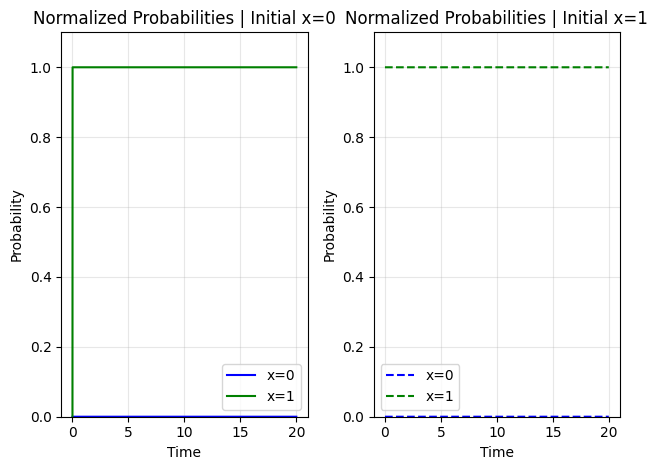

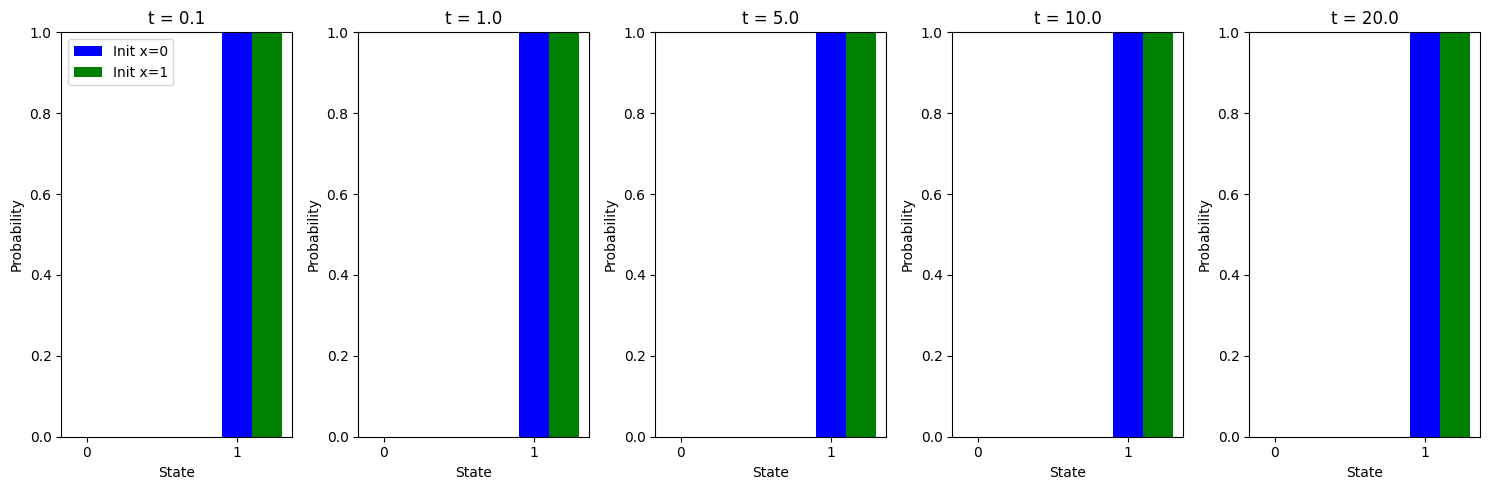

In [6]:
# Create state indices array for weighting
state_indices = np.arange(solution.shape[2])  # [0, 1, 2, ...]

# Compute weighted sum (expectation value)
weighted_norm_factors = np.sum(solution * state_indices, axis=2, keepdims=True)

# Safe division (skip where denominator is zero)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_solution = (solution * state_indices) / weighted_norm_factors
    normalized_solution = np.nan_to_num(normalized_solution)  # Convert NaN/inf to 0

# Plot for each initial condition
for initial_state in range(solution.shape[0]):
    plt.subplot(1, solution.shape[0], initial_state+1)
    
    for state in range(solution.shape[2]):
        plt.plot(t_eval, normalized_solution[initial_state, :, state],
                color=colors[state],
                linestyle=line_styles[initial_state % len(line_styles)],
                label=f'x={state}')
    
    plt.title(f'Normalized Probabilities | Initial x={initial_state}')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional plot: State probabilities at specific times
selected_times = [0.1, 1.0, 5.0, 10.0, 20.0]
time_indices = [np.argmin(np.abs(t_eval - t)) for t in selected_times]

plt.figure(figsize=(15, 5))
for i, t_idx in enumerate(time_indices):
    plt.subplot(1, len(time_indices), i+1)
    
    for initial_state in range(solution.shape[0]):
        plt.bar(np.arange(solution.shape[2]) + initial_state*0.2,
               normalized_solution[initial_state, t_idx],
               width=0.2,
               color=colors[initial_state],
               label=f'Init x={initial_state}' if i==0 else "")
    
    plt.title(f't = {t_eval[t_idx]:.1f}')
    plt.xlabel('State')
    plt.ylabel('Probability')
    plt.xticks(np.arange(solution.shape[2]))
    plt.ylim(0, 1)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

As a summary, we have code that generates the:

- steady state distribution
- probability that the next detection event occurs at time $t$, given an initial condition
- probability of state $x$ given a detection event occurs at time $t$ given an initial condition
- probability that we observe a time $t_l$ since the last detection event, given an initial condition

From these distributions, we can now compute the probability of any sequence of detection events by multiplying appropriately.

# Code for All Distribution Generation Functions

The code to generate all the distributions is put together here.

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from binary_markov_funcs import two_state_system_dt, two_state_system_detection_dt

# Simulation parameters
initial_p = np.array([1.0, 0.0])  # Start in OFF state
k_on = 1.0
k_off = 1.0
alpha = 2.0

t_max = 50.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)
num_time_points = len(t_eval)

# Run simulation and save
solution = solve_ivp(two_state_system_dt, [0, t_max], initial_p, 
                    t_eval=t_eval, method='RK45', args=(k_off, k_on))
steady_state = solution.y[:, -1]  # Final probabilities
np.save('steady_state.npy', steady_state) # SAVE THE STEADY STATE SOLUTION

# The initial steady state conditioned on a detectable event occuring
state_indices = np.arange(steady_state.shape[0])  # [0, 1, 2, ...]
weighted_init_norm_factors = np.sum(steady_state * state_indices, keepdims=True)
# Safe division (skip where denominator is zero)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_init_state = (steady_state * state_indices) / weighted_init_norm_factors
    normalized_init_state = np.nan_to_num(normalized_init_state)  # Convert NaN/inf to 0
np.save('steady_state_with_detection.npy', normalized_init_state) # SAVE THE STEADY STATE SOLUTION

# Run detection simulation for each initial condition
num_states = 2  # Number of initial states in the system (user specifies this)
solution = np.zeros((num_states, num_time_points, num_states))

for initial_state in range(num_states):
    # Create initial condition (100% in current state)
    initial_p = np.zeros(num_states)
    initial_p[initial_state] = 1.0
    # Solve ODE system
    sol = solve_ivp(two_state_system_detection_dt, [0, t_max], initial_p, 
                   t_eval=t_eval, method='RK45', args=(k_off, k_on, alpha))
    # Store solution in array (solution[initial_state, time_index, state_value])
    solution[initial_state, :, :] = sol.y.T
np.save('ode_solutions.npy', solution) # SAVE THE ODE SOLUTION

# Normalize each initial condition's solution, to find the probability of randomly observing
# a particular time since the last event and the current state
normalized_solution = np.zeros_like(solution)
for initial_state in range(solution.shape[0]):
    # Sum over states for each time point (keep dimensions for broadcasting)
    norm_factors = np.sum(solution[initial_state]*dt)
    normalized_solution[initial_state] = solution[initial_state] / norm_factors
np.save('time_since_last_event.npy', normalized_solution)

# Create marginalized array by summing over x values (axis=2)
marginalized = np.sum(solution, axis=2)  # Shape: [initial_conditions, time_points]
# Compute death probability density (negative time derivative of S)
death_prob = -np.diff(marginalized, axis=1) / dt  # Finite difference derivative
# Pad with zero to match original array size
death_prob = np.pad(death_prob, ((0,0),(0,1)), mode='constant') #Shape: [initial_conditions, time_points]
np.save('death_probs.npy', death_prob) # SAVE THE PROBABILITY OF DEATH AT TIME INDEX GIVEN INITIAL CONDITION 

# Create state indices array for weighting
state_indices = np.arange(solution.shape[2])  # [0, 1, 2, ...]
# Compute weighted sum (expectation value), to normalize by the probability of the current x given t and init
weighted_norm_factors = np.sum(solution * state_indices, axis=2, keepdims=True)
# Safe division (skip where denominator is zero)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_solution = (solution * state_indices) / weighted_norm_factors
    normalized_solution = np.nan_to_num(normalized_solution)  # Convert NaN/inf to 0
np.save('prob_x_given_t_and_init.npy', normalized_solution) # SAVE THE PROBABILITY OF X given a reaction time and initial condition 

print ("Done producing the relevant pdfs!")

Done producing the relevant pdfs!


## Loading Distributions

In [9]:
import numpy as np
# With our code, we now want to generate the probability distribution
# Load each array
steady_state = np.load('steady_state.npy')
steady_state_with_detection = np.load('steady_state_with_detection.npy')
ode_solutions = np.load('ode_solutions.npy')
time_since_last_event = np.load('time_since_last_event.npy')
death_probs = np.load('death_probs.npy')
prob_x_given_t_and_init = np.load('prob_x_given_t_and_init.npy')

# Now you can use these arrays in your code
print("Steady state solution shape:", steady_state.shape)
print("Steady state with detection:", steady_state_with_detection)
print("ODE solutions shape:", ode_solutions.shape)
print("Time since last event shape:", time_since_last_event.shape)
print("Death probabilities shape:", death_probs.shape)
print("Probability of X given t and init shape:", prob_x_given_t_and_init.shape)

Steady state solution shape: (2,)
Steady state with detection: [0. 1.]
ODE solutions shape: (2, 5000, 2)
Time since last event shape: (2, 5000, 2)
Death probabilities shape: (2, 5000)
Probability of X given t and init shape: (2, 5000, 2)


## Comparisons with Analytical Distribution

We compare the value of the probabilities obtained from our numerical solution with the analytical solution we've derived earlier, as well as the entropies.

In [14]:
from binary_markov_funcs import two_state_analytical_solution

# Imagine we want to the probability distribution of (init cond, time index, current state)
# then we grab the steady state with detection[init cond] * time_since_last_event[time index, current state]

init_cond = 1
current_state = 0

t_max = 50.0  # Total simulation time
dt = 0.01  # Time step size (user can adjust)
t_eval = np.arange(0, t_max, dt)
num_time_points = len(t_eval)

time_index = 20
print ("Evaluating at time ", t_eval[time_index])

print ("Numerical Poff = ", steady_state_with_detection[init_cond] * ode_solutions[init_cond, time_index, 0])
print ("Numerical Pon = ", steady_state_with_detection[init_cond] * ode_solutions[init_cond, time_index, 1])

print ("Ratio Pon/Poff = ",  time_since_last_event[init_cond, time_index, 1]/time_since_last_event[init_cond, time_index, 0])

k_on = 1.0
k_off = 1.0
alpha = 2.0

P_on, P_off = two_state_analytical_solution(k_on, k_off, alpha, t_eval)
print ("Analytical Poff = ", P_off[time_index])
print ("Analytical Pon = ", P_on[time_index])
print ("Ratio Pon/Poff = ", P_on[time_index] / P_off[time_index])

Evaluating at time  0.2
Numerical Poff =  0.13589402264996103
Numerical Pon =  0.5613680793331645
Ratio Pon/Poff =  4.13092546961502
Analytical Poff =  0.135858693044725
Analytical Pon =  0.5614533841982144
Ratio Pon/Poff =  4.132627597215165


In [20]:
#Numerical Mutual Information Calculation
def numerical_prob_x_t_xi(init_cond, time_index, current_x, steady_state_with_detection, time_since_last_event):
    return steady_state_with_detection[init_cond] * time_since_last_event[init_cond, time_index, current_x]

# To compute the entropy, we go through all the states
joint_entropy = 0
time_entropy = 0
for time_index in range(len(t_eval)):
    prob_t = 0
    for current_x in range(2):
        prob_x_t = 0
        for init_cond in range(1, 2): #No need to consider initial condition 0, since it has 0 probability.
            prob_x_t_xi = numerical_prob_x_t_xi(init_cond, time_index, current_x, steady_state_with_detection, time_since_last_event)
            prob_x_t += prob_x_t_xi
        if prob_x_t > 1e-10:
            joint_entropy += -prob_x_t * np.log2(prob_x_t)*dt
        prob_t += prob_x_t
    if prob_t > 1e-10:
        time_entropy += -prob_t * np.log2(prob_t)*dt
print ("The joint entropy is ", joint_entropy)
print ("The time entropy is ", time_entropy)
print ("The difference is ", joint_entropy - time_entropy)

The joint entropy is  2.8274669551166567
The time entropy is  2.005719747043745
The difference is  0.8217472080729116


Compare with our analytical solution:

In [19]:
from binary_markov_funcs import two_state_analytical_solution, mutual_information_calc

k_on = 1.0  # OFF -> ON rate
k_off = 1.0  # ON -> OFF rate
alpha = 2.0

mutual_information, joint_entropy, survival_time_entropy, x_entropy = mutual_information_calc(k_on, k_off, alpha, t_eval, dt)
print ("The joint entropy is ", joint_entropy)
print ("The time entropy is ", time_entropy)
print ("The difference is ", joint_entropy - time_entropy)

The joint entropy is  2.8271746625187193
The time entropy is  2.005719747043745
The difference is  0.8214549154749742


We observe our numerical solution agrees with the analytical solution in predictions for the mutual information.

## Filler


Instead, we show that all of our previous results can be extended via numerical solutions.

Our purely numerical procedure to calculate the mutual information between static distributions works as follows.

First, we compute the steady state probability distribution of the underlying system. This involves numerically solving the system of ODEs for any arbitrary initial condition.

Next, we compute the probability distribution that given an initial condition, the system has yet to produce a detection event. This involves numerically solving a modified system of ODEs for all the possible initial conditions, which we typically consider only a finite set of. These distributions must be saved appropriately.

From these distributions, we compute the probability that a detection event occurs at $t_l$, and the probabilities of specific $x$ values when that event has occurred at this time. Earlier, we obtained the probability distribution of $x, t_l$ where it has survived for at least $t_l$. We sum over all the $x$ values and obtain the survival probability $P(t_l)$, and take the derivative for the probability a detection event occurs at that time.

For the probability of the specific $x$ value when the event has occured at $t_l$, we normalize the probabilities of all the values of $x$ at time $t_l$, and then multiply by $x$. This ensures the states that are more likely to produce detection events are more likely.

We save these into a series of arrays.